# Лабораторная работа №1

> =========================================
>
> Тема: Кластеризация, снижение размерности пространства признаков
>
> Набор данных: Настольные игры
>
> Студент: Цветков Иван ИУ7-22М
> 
>=========================================

## 0. Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

## 1. Данные

### 1.1. Чтение

In [2]:
pd.set_option('display.max_columns', None)

dfInit = pd.read_csv('./data/bgg_dataset.csv', delimiter=';', encoding='utf8')
del dfInit["ID"]


df = dfInit.copy(deep=True)

df

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,Gloomhaven,2017.0,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,"8,61",2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,Brass: Birmingham,2018.0,2,4,120,14,19217,"8,66",3,"3,91",28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,Terraforming Mars,2016.0,1,5,120,12,64864,"8,43",4,"3,24",87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,"8,70",5,"4,22",16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,War,0.0,2,2,30,4,1340,"2,28",20340,1,427.0,NaN,Children's Games
20339,Bingo,1530.0,2,99,60,5,2154,"2,85",20341,"1,05",1533.0,"Betting and Bluffing, Bingo, Pattern Recognition",Party Games
20340,Candy Land,1949.0,2,4,30,3,4006,"3,18",20342,"1,08",5788.0,Roll / Spin and Move,Children's Games
20341,Chutes and Ladders,-200.0,2,6,30,3,3783,"2,86",20343,"1,02",4400.0,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games


### 1.2. Преобразование

In [3]:
del df["Name"]
del df["Mechanics"]
del df["Domains"]
df.drop("Min Players", axis=1, inplace=True)
df.dropna(axis=0, inplace=True)

# Приведение данных к числу
df["Rating Average"] = df["Rating Average"].str.replace(",", ".")
df["Rating Average"] = df["Rating Average"].map(lambda elem: float(elem))

df["Complexity Average"] = df["Complexity Average"].str.replace(",", ".")
df["Complexity Average"] = df["Complexity Average"].map(lambda elem: float(elem))



df

,Year Published,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
0,2017.0,4,120,14,42055,8.79,1,3.86,68323.0
1,2015.0,4,60,13,41643,8.61,2,2.84,65294.0
2,2018.0,4,120,14,19217,8.66,3,3.91,28785.0
3,2016.0,5,120,12,64864,8.43,4,3.24,87099.0
4,2017.0,6,480,14,13468,8.70,5,4.22,16831.0
...,...,...,...,...,...,...,...,...,...
20338,0.0,2,30,4,1340,2.28,20340,1.00,427.0
20339,1530.0,99,60,5,2154,2.85,20341,1.05,1533.0
20340,1949.0,4,30,3,4006,3.18,20342,1.08,5788.0
20341,-200.0,6,30,3,3783,2.86,20343,1.02,4400.0


### 1.3. Нормализация

In [4]:
dfCopy = df.copy(deep=True)
# Мин-макс нормализация
df = (df - df.min()) / (df.max() - df.min())

df

,Year Published,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
0,0.999095,0.004004,0.002000,0.56,0.411268,0.907386,0.000000,0.772,0.439908
1,0.998732,0.004004,0.001000,0.52,0.407236,0.886284,0.000049,0.568,0.420405
2,0.999276,0.004004,0.002000,0.56,0.187769,0.892145,0.000098,0.782,0.185337
3,0.998913,0.005005,0.002000,0.48,0.634483,0.865182,0.000147,0.648,0.560800
4,0.999095,0.006006,0.008000,0.56,0.131508,0.896835,0.000197,0.844,0.108369
...,...,...,...,...,...,...,...,...,...
20338,0.633828,0.002002,0.000500,0.16,0.012820,0.144197,0.999803,0.200,0.002749
20339,0.910902,0.099099,0.001000,0.20,0.020786,0.211020,0.999853,0.210,0.009870
20340,0.986780,0.004004,0.000500,0.12,0.038910,0.249707,0.999902,0.216,0.037267
20341,0.597610,0.006006,0.000500,0.12,0.036728,0.212192,0.999951,0.204,0.028330


### 1.4. Проверка выбросов

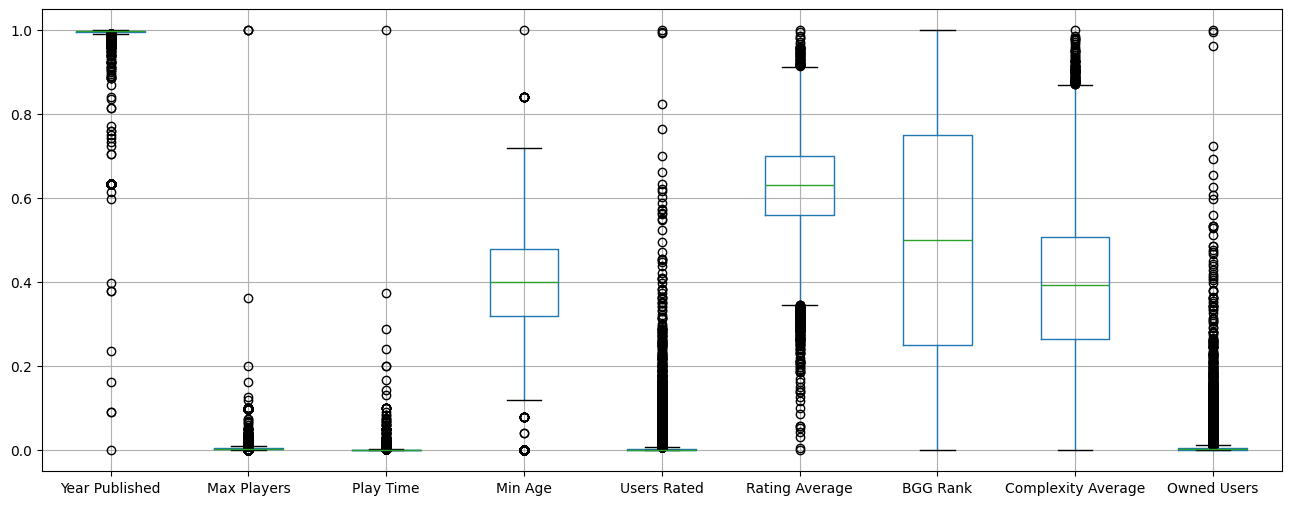

In [5]:
ax = df.boxplot(column=list(df.columns), figsize=(16,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

### 1.5. Удаление выбросов

#### 1.4.1. Поле "Year Published"

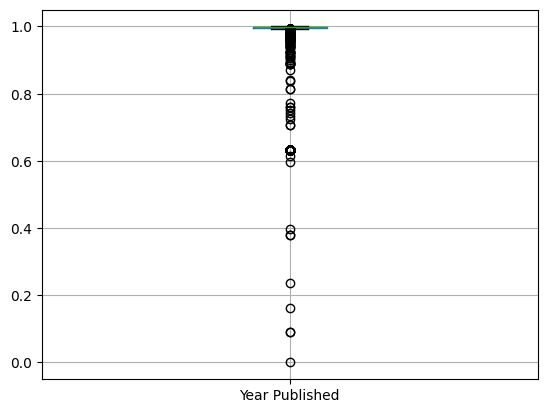

In [6]:
# 1. Просмотреть выбросы
df.boxplot(column=["Year Published"])
plt.show()

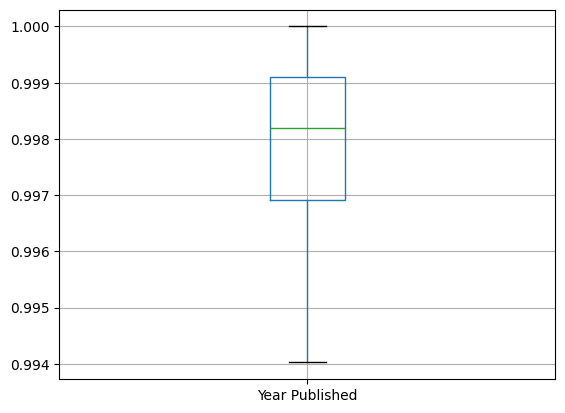

In [7]:
# 2. Удалить выбросы
indexesToDelete = df[df["Year Published"] < 0.994].index

df = df.drop(indexesToDelete, axis=0)
dfCopy = dfCopy.drop(indexesToDelete, axis=0)

# 3. Проверить результат
df.boxplot(column=["Year Published"])
plt.show()

#### 1.4.2. Поле "Max Players"

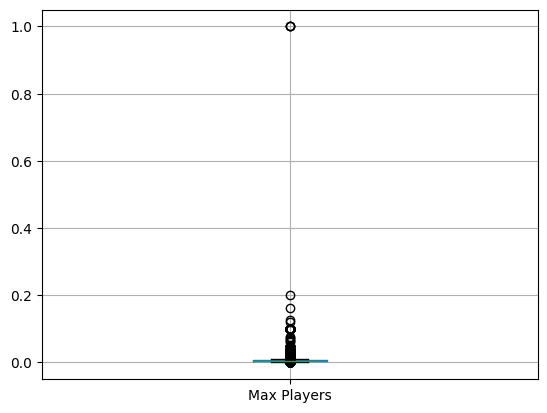

In [8]:
# 1. Просмотреть выбросы
df.boxplot(column=["Max Players"])
plt.show()

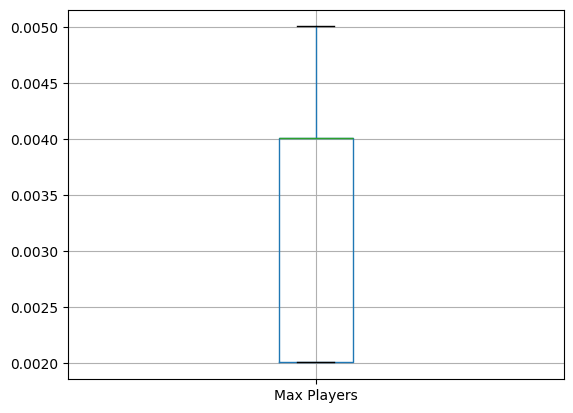

In [9]:
# 2. Удалить выбросы
indexesToDelete = df[(df["Max Players"] < 0.0015) | (df["Max Players"] > 0.006)].index

df = df.drop(indexesToDelete, axis=0)
dfCopy = dfCopy.drop(indexesToDelete, axis=0)

# 3. Проверить результат
df.boxplot(column=["Max Players"])
plt.show()

#### 1.4.3. Поле "Play Time"

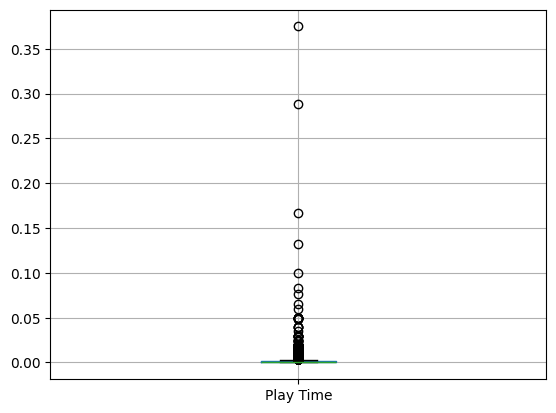

In [10]:
# 1. Просмотреть выбросы
df.boxplot(column=["Play Time"])
plt.show()

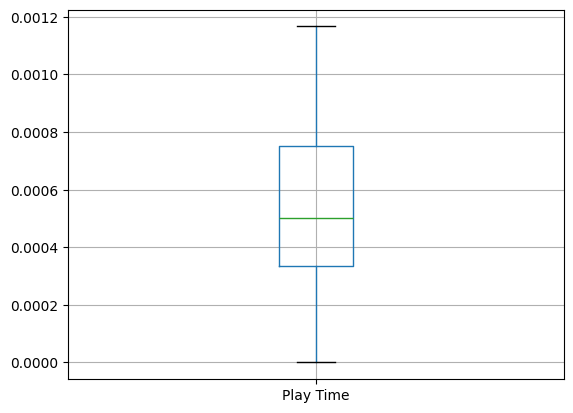

In [11]:
# 2. Удалить выбросы
indexesToDelete = df[(df["Play Time"] > 0.0012)].index

df = df.drop(indexesToDelete, axis=0)
dfCopy = dfCopy.drop(indexesToDelete, axis=0)

# 3. Проверить результат
df.boxplot(column=["Play Time"])
plt.show()

#### 1.4.4. Поле "Min Age"

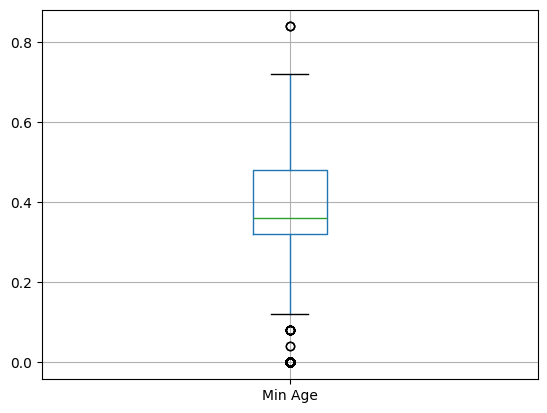

In [12]:
# 1. Просмотреть выбросы
df.boxplot(column=["Min Age"])
plt.show()

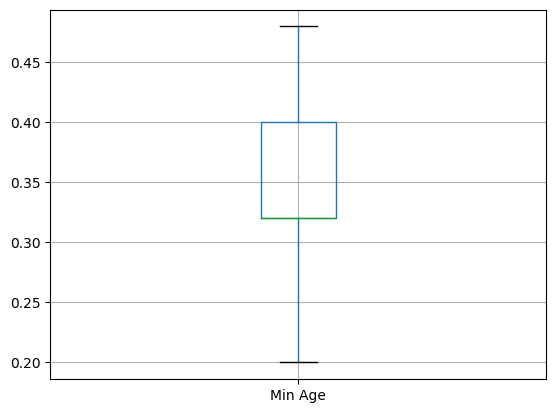

In [13]:
# 2. Удалить выбросы
indexesToDelete = df[(df["Min Age"] < 0.2) | (df["Min Age"] > 0.5)].index

df = df.drop(indexesToDelete, axis=0)
dfCopy = dfCopy.drop(indexesToDelete, axis=0)

# 3. Проверить результат
df.boxplot(column=["Min Age"])
plt.show()

#### 1.4.5. Поле "Users Rated"

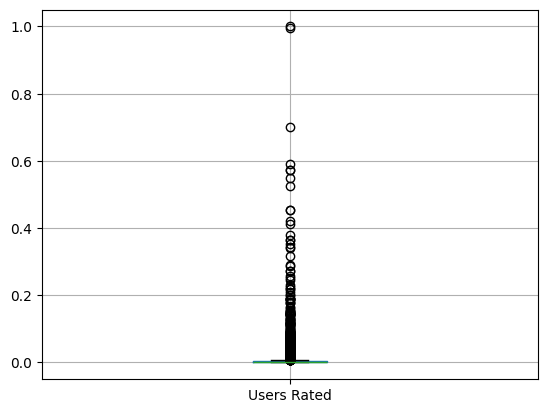

In [14]:
# 1. Просмотреть выбросы
df.boxplot(column=["Users Rated"])
plt.show()

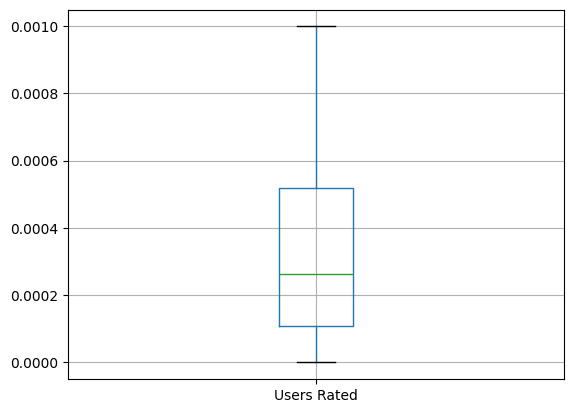

In [15]:
# 2. Удалить выбросы
indexesToDelete = df[(df["Users Rated"] > 0.001)].index

df = df.drop(indexesToDelete, axis=0)
dfCopy = dfCopy.drop(indexesToDelete, axis=0)

# 3. Проверить результат
df.boxplot(column=["Users Rated"])
plt.show()

#### 1.4.6. Поле "Rating Average"

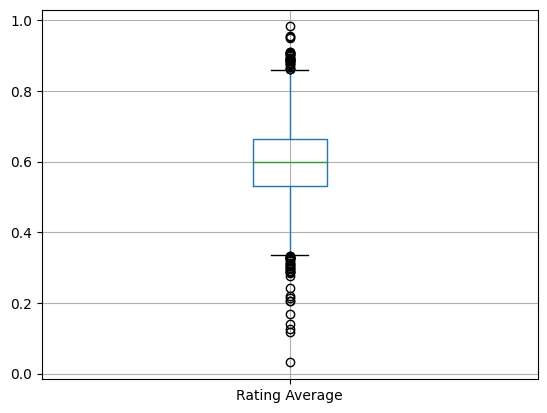

In [16]:
# 1. Просмотреть выбросы
df.boxplot(column=["Rating Average"])
plt.show()

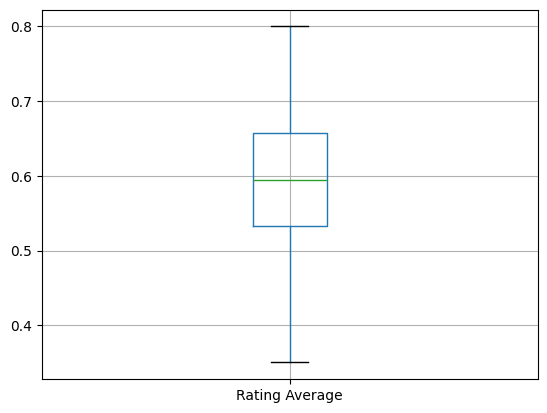

In [17]:
# 2. Удалить выбросы
indexesToDelete = df[(df["Rating Average"] < 0.35) | (df["Rating Average"] > 0.8)].index

df = df.drop(indexesToDelete, axis=0)
dfCopy = dfCopy.drop(indexesToDelete, axis=0)

# 3. Проверить результат
df.boxplot(column=["Rating Average"])
plt.show()

#### 1.4.7. Поле "Complexity Average"

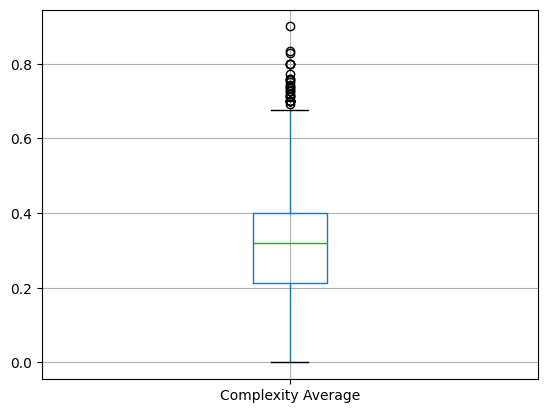

In [18]:
# 1. Просмотреть выбросы
df.boxplot(column=["Complexity Average"])
plt.show()

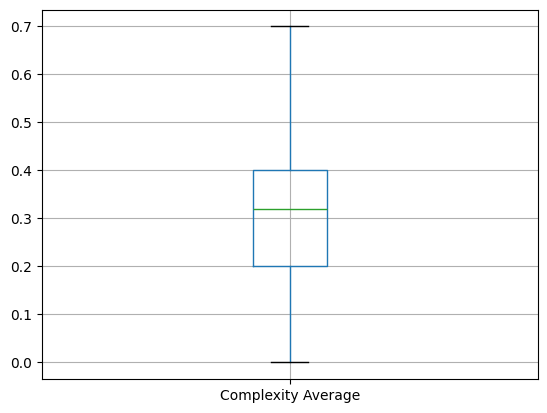

In [19]:
# 2. Удалить выбросы
indexesToDelete = df[(df["Complexity Average"] > 0.7)].index

df = df.drop(indexesToDelete, axis=0)
dfCopy = dfCopy.drop(indexesToDelete, axis=0)

# 3. Проверить результат
df.boxplot(column=["Complexity Average"])
plt.show()

#### 1.4.8. Поле "Owned Users"

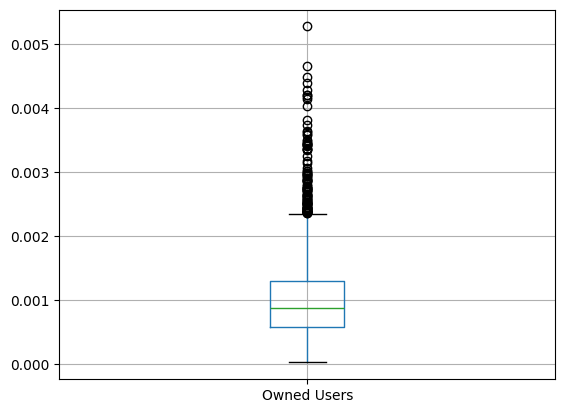

In [20]:
# 1. Просмотреть выбросы
df.boxplot(column=["Owned Users"])
plt.show()

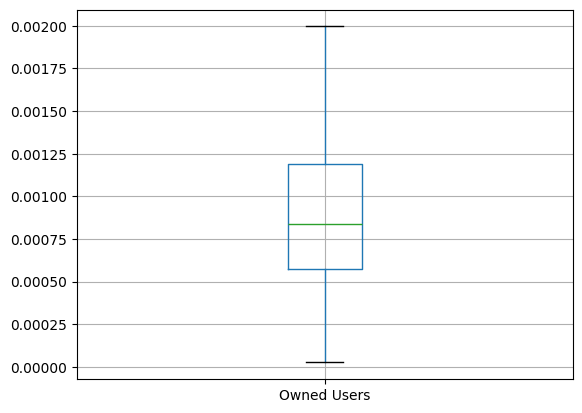

In [21]:
# 2. Удалить выбросы
indexesToDelete = df[(df["Owned Users"] > 0.002)].index

df = df.drop(indexesToDelete, axis=0)
dfCopy = dfCopy.drop(indexesToDelete, axis=0)

# 3. Проверить результат
df.boxplot(column=["Owned Users"])
plt.show()

### 1.6. Повторная проверка выбросов

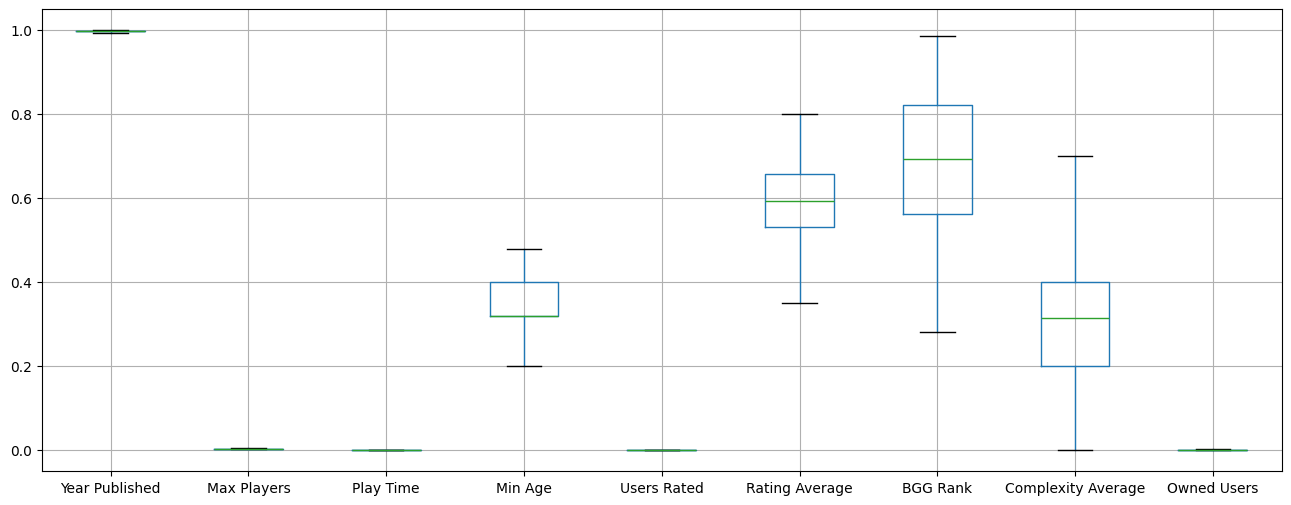

In [22]:
ax = df.boxplot(column=list(df.columns), figsize=(16,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

## 2. Выполнение

### 2.1. Визуализация данных

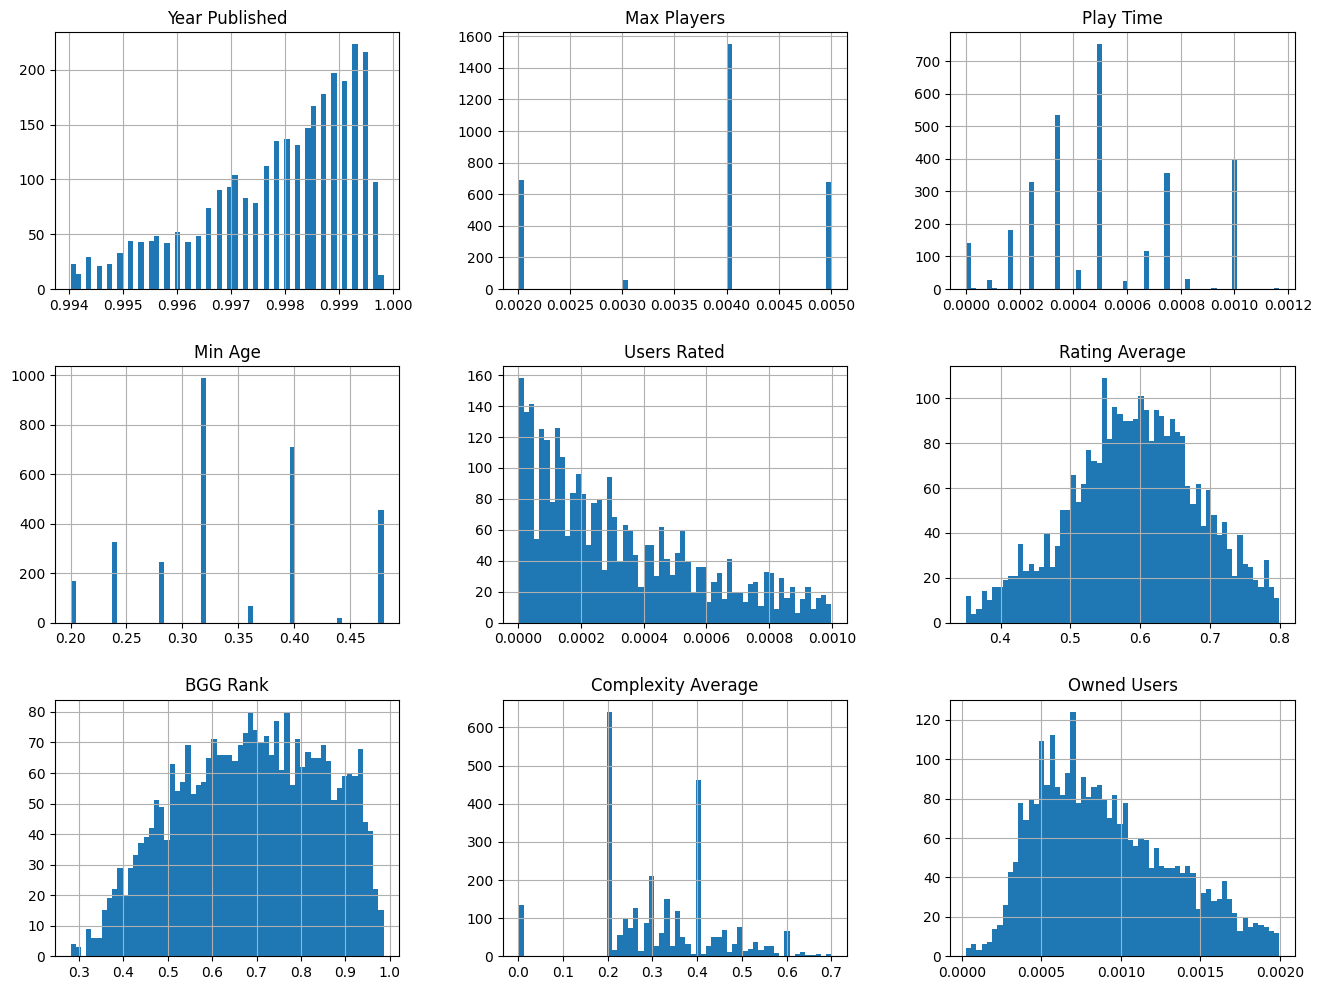

In [23]:
df.hist(bins=60, figsize=(16,12), grid=True)
plt.show()

### 2.2. Тепловая карта (корреляция признаков)

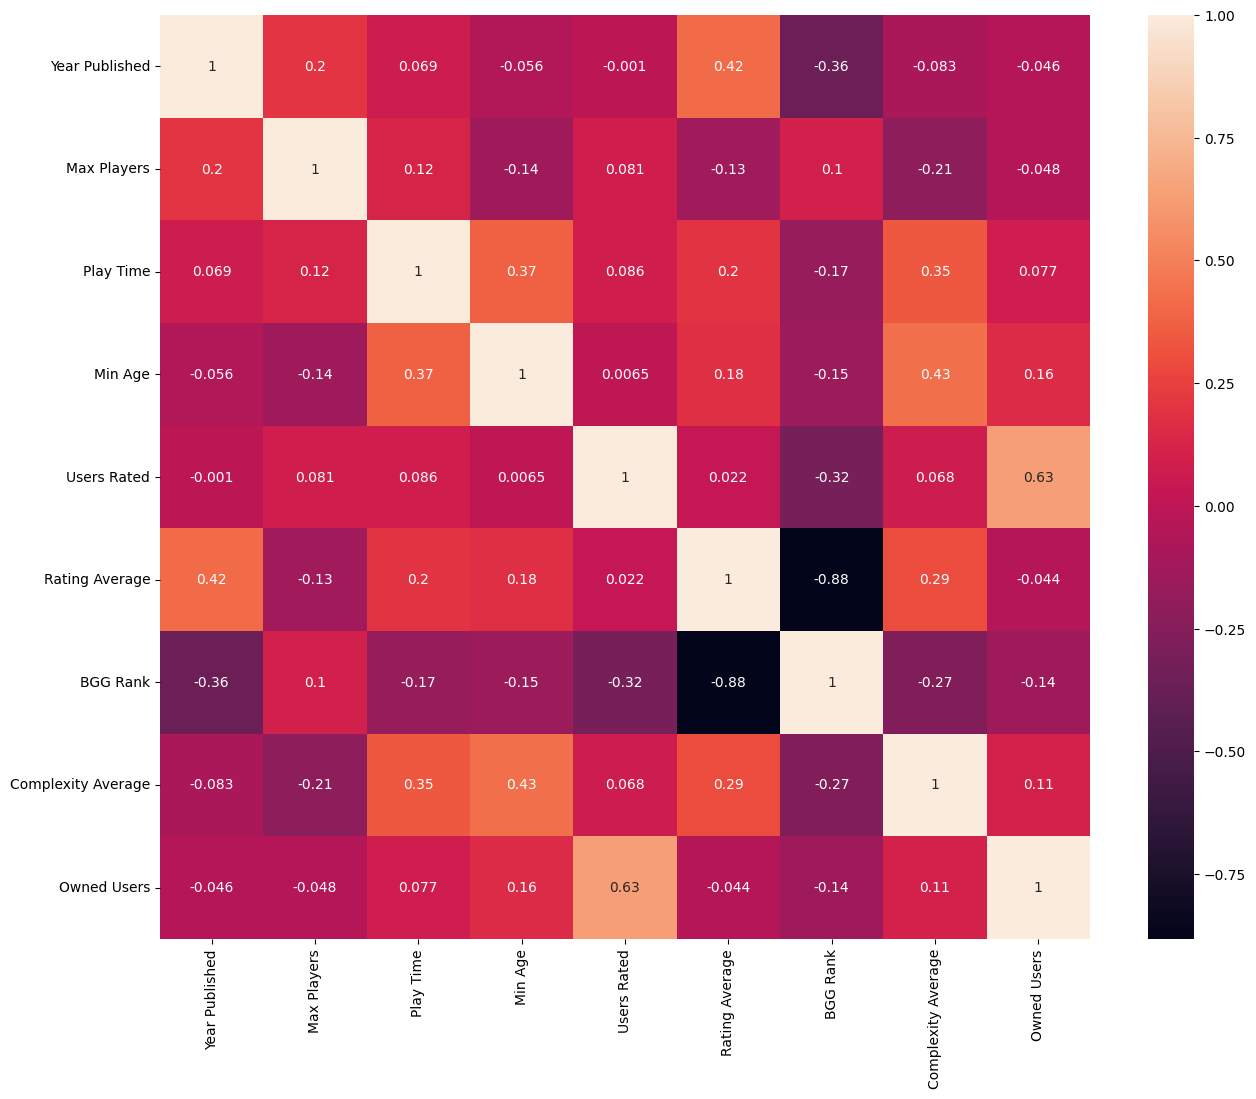

In [24]:
plt.figure(figsize=(15,12))
sns.heatmap(df.corr().round(decimals=4), annot=True)
plt.show()

### 2.3. k-means

In [25]:
import warnings
warnings.filterwarnings("ignore") # убрать FutureWarning (возникает в KMeans функции)

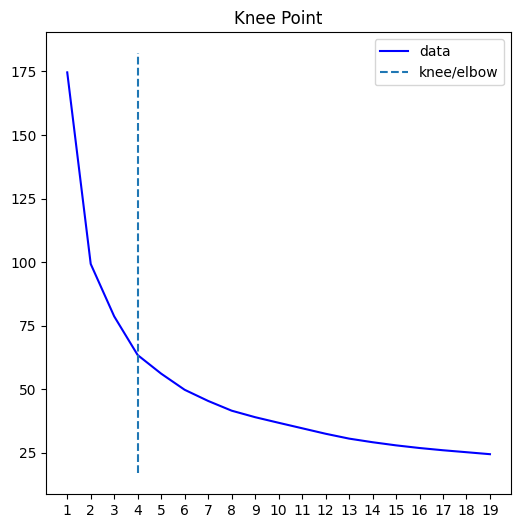

'clusters = Counter({1: 830, 3: 746, 0: 725, 2: 672})'

In [36]:
distortions = []
k = range(1, 20)

for kInd in k:
  kmeanModel = KMeans(n_clusters=kInd)
  kmeanModel.fit(df)
  # Сумма квадратов расстояний выборок до их ближайшего центра кластера
  distortions.append(kmeanModel.inertia_)

kneeLocator = KneeLocator(
  k,
  distortions,
  curve="convex",
  direction="decreasing"
)

# График
kneeLocator.plot_knee()
plt.xticks(np.arange(min(k), max(k) + 1, 1.0))
plt.show()


# Кластеоы
kmeanModel = KMeans(n_clusters=kneeLocator.knee)
kmeanModel = kmeanModel.fit_predict(df)

display(f"clusters = {Counter(kmeanModel)}")

### 2.4. DBSCAN

'knee = 0.042312983483325343'

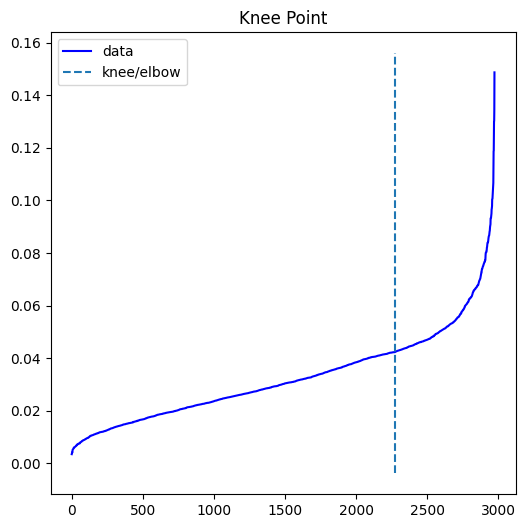

'clusters = Counter({-1: 1486, 0: 1048, 4: 278, 5: 28, 8: 25, 2: 24, 1: 23, 9: 13, 10: 13, 3: 12, 6: 12, 7: 11})'

In [27]:
# Поиск knee
neighbors = NearestNeighbors().fit(df)
neighborsDist, neighborsInd = neighbors.kneighbors(df)
sortNeighborDist = np.sort(neighborsDist, axis=0)

x = range(1, len(neighborsDist) + 1)
y = sortNeighborDist[:, 3]

kneeLocator = KneeLocator(x, y, curve="convex", S=35)
knee = kneeLocator.knee_y
display(f"knee = {knee}")

# График
kneeLocator.plot_knee()
plt.show()

# Кластеры
clusters = DBSCAN(eps=knee, min_samples=13).fit(df)
display(f"clusters = {Counter(clusters.labels_)}")

### 2.5. PCA (Метод главных компонент)

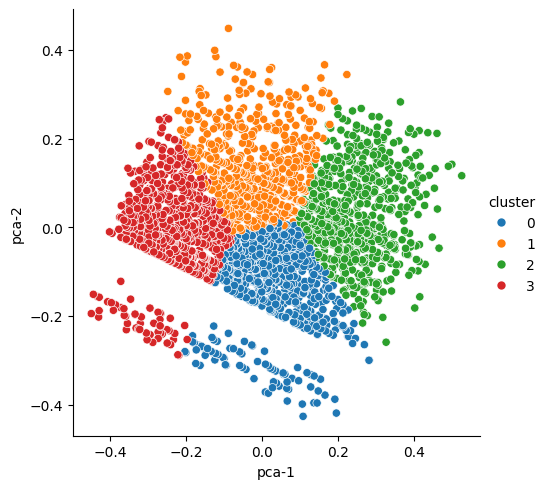

In [28]:
# Используя результаты k-means
subsetLen = len(df)
subsetDf = df[:subsetLen]

PCAModel = PCA(n_components=2)
PCAData = PCAModel.fit_transform(subsetDf)

PCADf = pd.DataFrame()
PCADf['pca-1'] = PCAData[:, 0]
PCADf['pca-2'] = PCAData[:, 1]

PCADf['cluster'] = kmeanModel[: subsetLen]
PCADf['cluster'] = PCADf['cluster'].astype('category')

sns.relplot(x='pca-1', y='pca-2', hue="cluster", data=PCADf)
plt.show()

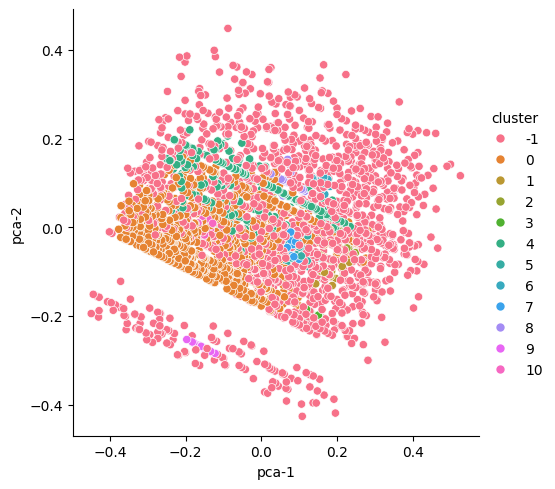

In [29]:
# Используя результаты DBSCAN
PCADf['cluster'] = clusters.labels_[:subsetLen]
PCADf['cluster'] = PCADf['cluster'].astype('category')

sns.relplot(x='pca-1', y='pca-2', hue="cluster", data=PCADf)
plt.show()

### 2.6. t-SNE (Стохастическое вложение соседей с t-распределением)

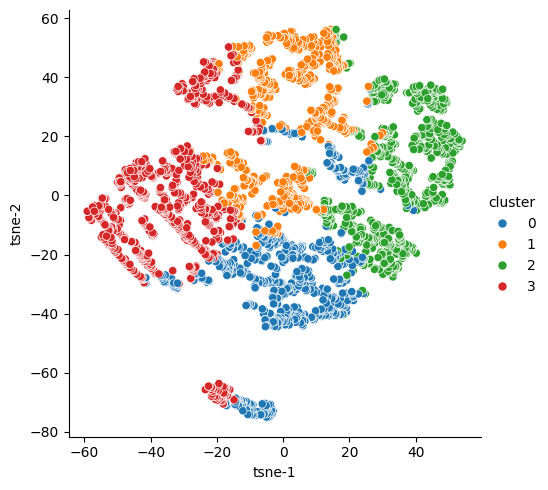

In [30]:
# Используя результаты k-means
subsetLen = len(df)
subsetDf = df[:subsetLen]

tSNEModel = TSNE(n_components=2)
tSNEData = tSNEModel.fit_transform(subsetDf)

tSNEDf = pd.DataFrame()
tSNEDf['tsne-1'] = tSNEData[:, 0]
tSNEDf['tsne-2'] = tSNEData[:, 1]

tSNEDf['cluster'] = kmeanModel[: subsetLen]
tSNEDf['cluster'] = tSNEDf['cluster'].astype('category')

sns.relplot(x='tsne-1', y='tsne-2', hue="cluster", data=tSNEDf)
plt.show()

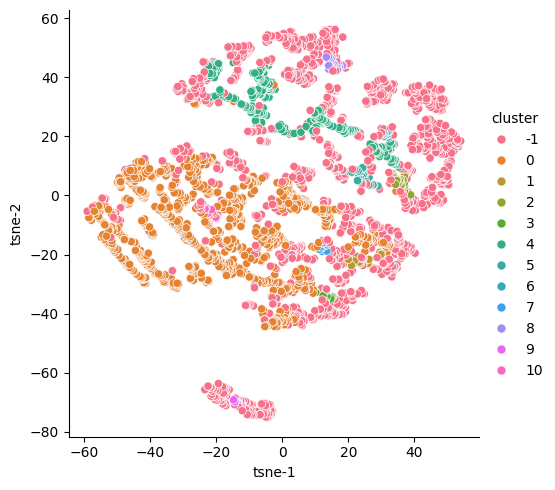

In [31]:
# Используя результаты DBSCAN
tSNEDf['cluster'] = clusters.labels_[:subsetLen]
tSNEDf['cluster'] = tSNEDf['cluster'].astype('category')

sns.relplot(x='tsne-1', y='tsne-2', hue="cluster", data=tSNEDf)
plt.show()

In [32]:
dfCopy['cluster_kmeans'] = kmeanModel
dfCopy['cluster_kmeans'] = dfCopy['cluster_kmeans'].astype('category')

dfCopyFilter = dfCopy[dfCopy.cluster_kmeans == 0]
dfCopyFilter.describe()

,Year Published,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,2012.631081,3.937838,24.389189,7.664865,63.136486,6.406865,12617.036486,1.088865,133.021622
std,6.896714,0.952982,12.515317,1.703648,25.665413,0.428136,1800.618687,0.444147,62.006216
min,1989.000000,2.000000,0.000000,5.000000,30.000000,5.670000,6525.000000,0.000000,13.000000
25%,2010.000000,4.000000,15.000000,6.000000,43.000000,6.090000,11466.000000,1.000000,84.750000
50%,2015.000000,4.000000,20.000000,8.000000,58.000000,6.330000,12833.500000,1.000000,122.000000
75%,2018.000000,5.000000,30.000000,8.000000,79.000000,6.650000,14049.500000,1.400000,174.000000
max,2021.000000,5.000000,60.000000,12.000000,132.000000,7.860000,15572.000000,2.000000,309.000000


In [33]:
dfCopyFilter = dfCopy[dfCopy.cluster_kmeans == 1]
dfCopyFilter.describe()

,Year Published,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
count,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,2008.220238,3.651786,34.922619,9.811012,55.663690,5.929315,15308.058036,2.106652,137.644345
std,7.977372,1.121872,17.833473,1.756826,23.847253,0.460171,1571.321350,0.417739,62.993057
min,1989.000000,2.000000,0.000000,5.000000,30.000000,4.290000,12234.000000,1.300000,6.000000
25%,2003.000000,2.000000,20.000000,8.000000,37.000000,5.660000,14044.750000,1.830000,88.000000
50%,2010.000000,4.000000,30.000000,10.000000,48.000000,5.920000,15176.500000,2.000000,129.000000
75%,2015.000000,4.000000,45.000000,12.000000,69.000000,6.240000,16367.250000,2.330000,180.000000
max,2021.000000,5.000000,70.000000,12.000000,131.000000,7.180000,19953.000000,3.500000,310.000000
